In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tkinter import filedialog
import os
import seaborn as sns
import sys
sys.path.insert(1, '../Python Scripts')
import han
import sa_core as sa
%matplotlib inline


In [2]:
#custom = [(0,0,0), (0, 0, 73), (0, 146, 146), (255, 109, 182), (0, 182, 119), 
#         (73, 0, 146), (0, 109, 219), (182, 109, 255), (109, 182, 255), 
#         (182, 219, 255), (146, 0, 0), (146, 73, 0), (219, 209, 0),
#         (36, 255, 36), (255, 255, 109)]
custom = [(0, 0, 0), (255, 0, 102), (16, 127, 128), (64, 0, 127), (107, 102, 255), (102, 204, 254)]
custom = [tuple(np.array(list(rgb))/255) for rgb in custom]

palette = sa.plotting_palette()
#sns.palplot(palette)

sns.set(style="white")
sns.set_context("talk")
#sns.set_palette(palette)


In [3]:
#custom2 = [sns.light_palette(color, n_colors = 4, reverse=True)[:3] for color in custom]
#custom3 = np.array(custom2).reshape([18, 3]).tolist()
#custom4 = custom3[0::3]+custom3[1::3]+custom3[2::3]
#sns.palplot(sns.color_palette(custom4))

In [4]:
def loop():
    directory = filedialog.askdirectory()
    subdirs = os.listdir(directory)
    subdirs = [os.path.join(directory, subdir) for subdir in subdirs]
    print(subdirs)
    thresholds = [5, 5, 6, 5, 5, 5]
    for idx, subdir in enumerate(subdirs):
        han.get_spikes("Sample", None, min_std=thresholds[idx], max_std=20, io=2, subdir=subdir)
#loop()

In [5]:
#sa.spike_loop(1.5e-2)

In [6]:
"""Need to plot instantaneous rate for each spike type.
Also figure out how to do summary data for different spike types.
Plot average cumulative spike features.
Mean frequency of each unit
"""

def io(folder):
    file = pd.read_excel(os.path.join(folder,"block_analysis.xlsx"), sheet_name=None)
    return file


In [7]:
#file.keys()

In [8]:
def unit_rate(SN_rates, DR_rates):
    fig, axes = plt.subplots(nrows =2, figsize=(10,7))
    SN_rates.plot(ax=axes[0], linewidth=1.5)
    DR_rates.plot(ax=axes[1], linewidth=1.5)
    [ax.set_ylabel("Frequency (Hz)") for ax in axes]
    [ax.set_xlabel("Time (s)") for ax in axes]

#DR_rates = file["DR_unit_rates"].copy()
#DR_rates.set_index(DR_rates.columns[0], inplace=True)
#SN_rates = file["SN_unit_rates"].copy()
#SN_rates.set_index(SN_rates.columns[0], inplace=True)

#unit_rate(SN_rates, DR_rates)


In [9]:
def facet_plot(data, var, path):
    #palette = sns.color_palette("bright", n_colors= 20 )
    if (var == "STTC") | (var == "VRD"):
        data = data[data.Spiketrain=="Dorsal"]
        grid = sns.FacetGrid(data=data, col="Unit",
                             col_wrap=10, height=1.5, palette=palette)
    else:
        grid = sns.FacetGrid(data=data, col="Unit", hue="Spiketrain",
                             col_wrap=10, height=1.5, palette=palette)
    grid.map(plt.plot, "Epoch", var, marker="o")
    grid.add_legend()
    grid.savefig(path+"//"+var+".svg")
    



In [10]:
"""look at units that respond to capscacin and split into either responsive or not responsive-compare
filtering properties-set threshold by percentage change from control to cap.
Statistical analysis of whether spike_latency correlates with filtering.
Which variables e.g. latency, width - predict percentage filtered? Also STTC and VRD
Which variables e.g latency and width -  predict percentage freq change in capsaicin?
Does percentage filtered predict percentage freq change?
Create and export 1 dfs for R;
one with all the latencies, widths, etc and percentage filtered and percentage change under capsaicin.
Compare capsaicin responsive change in filtering between conditions and non-capsaicin responsive. Two way factors are
"sensitivity to capsaicin" and "condition". Dependent variable is %filtered
Create a loop function to loop through block analysis files and do this. Maybe include prep as blocking variable"""

def scrape_block_analysis():
    directory = filedialog.askdirectory()
    subdirs = os.listdir(directory)
    subdirs = [os.path.join(directory, subdir) for subdir in subdirs]
    core_df = pd.DataFrame()
    core_global = pd.DataFrame()
    for n, subdir in enumerate(subdirs):
        file = io(subdir)

        """Spinal nerve features"""
        SN_feats = file["SN_features"].copy()
        SN_feats.set_index(SN_feats.columns[0], inplace=True)
        SN_feats_mean = SN_feats.groupby("Clusters")["Prominence", "Peak_height", "Width"].mean()
        SN_feats_mean["Sample"] = [n+1]*SN_feats_mean.shape[0]
        concat = SN_feats_mean

        """Get mean unit latency"""
        latency = file["latency_desc"].copy()
        spike_type_map = latency["Fibre"].to_dict()
        
        latency_mean = latency["mean"]
        concat["latency"] = latency_mean

        """Extract % filtered by condition"""
        filtered = file["match_counts"].copy()
        filtered.set_index(filtered.iloc[:,0].fillna(method="ffill"), inplace=True)
        filt_pivot = filtered.pivot(columns = "st1_label", values="Percentage_Change").transpose()
        filt_pivot.columns = ["cap_filt", "control_filt", "gaba_filt"]
        concat = pd.concat([concat, filt_pivot], axis=1)

        """Average unit stats"""
        unit_stats = file["Unit_spike_stats"].copy()
        unit_stats.set_index(unit_stats.columns[0], inplace=True)
        unit_stats=unit_stats[(unit_stats.Epoch!="Full")&(unit_stats.Unit!=0)]
        facet_plot(unit_stats, "MeanFiringRate", subdir)
        facet_plot(unit_stats, "STTC", subdir)
        facet_plot(unit_stats, "VRD", subdir)
        facet_plot(unit_stats, "CV2", subdir)

        """Calculate freq change between control and capsaicin"""
        unit_freq_pivot =unit_stats[(unit_stats.Spiketrain=="Spinal")].pivot(columns = "Epoch", index="Unit", values = "MeanFiringRate")
        unit_freq_pivot.fillna(0, inplace=True)
        percent_change = unit_freq_pivot.cap-unit_freq_pivot.control
    
        """Define threshold-using 2Hz"""
        thresh_change = percent_change>2
        cap_sens_dict = thresh_change.to_dict()
        concat["firingchange"] = percent_change
        concat["Sens"] = concat.index.map(cap_sens_dict)
        concat["Fibre"] = concat.index.map(spike_type_map)
        concat = concat.iloc[1:, :]
        core_df = pd.concat([core_df, concat])
        
        global_stats = file["Global_spike_stats"]
        global_stats = global_stats[(global_stats.Epoch!="Full")]
        global_stats["Sample"] = [n+1]*global_stats.shape[0]
        core_global = pd.concat([core_global, global_stats])
        
    sns.catplot(kind="point", data=core_global, x="Epoch", y="MeanFiringRate", 
                    hue ="Spiketrain", order = ["control","cap","gaba"], ci=68, linewidth = 1.5, palette=palette)
    print("new")
    core_df.reset_index(inplace=True)
    return core_df, core_global

    


C:\Users\pierc\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\pierc\Anaconda3\lib\site-packages\seaborn\axisgrid.py:856: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
C:\Users\pierc\Anaconda3\lib\site-packages\seaborn\axisgrid.py:856: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
C:\Users\pierc\Anaconda3\lib\site-packages\seaborn\axisgrid.py:856: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
C:\Users\pierc\Anaconda3\lib\site-packages\seaborn\axisgrid.py:856: UserWarning: Tight layout not applied. The bottom and top ma

new


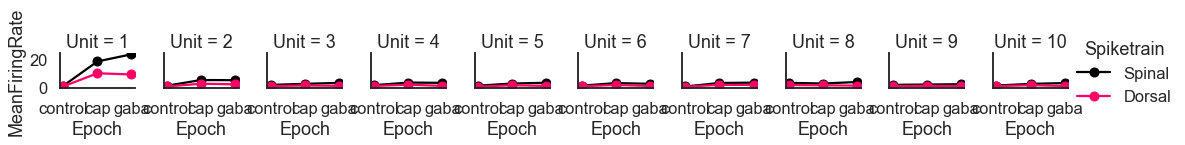

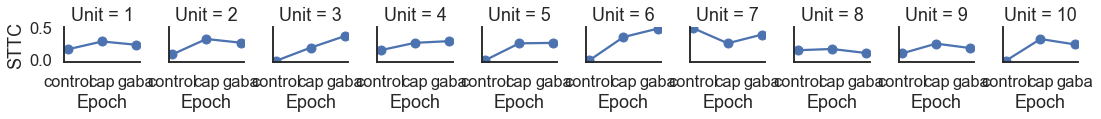

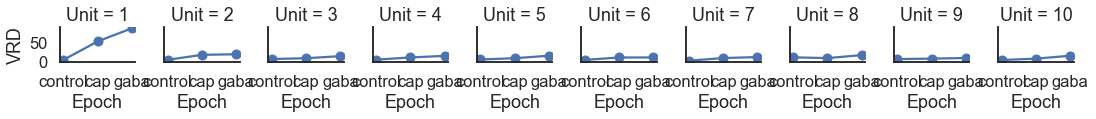

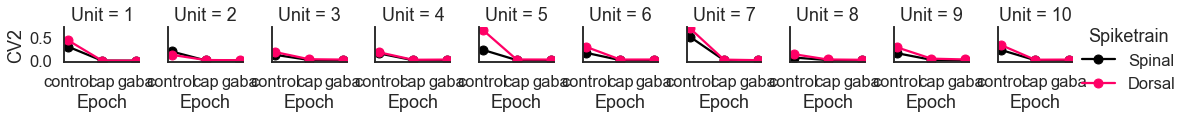

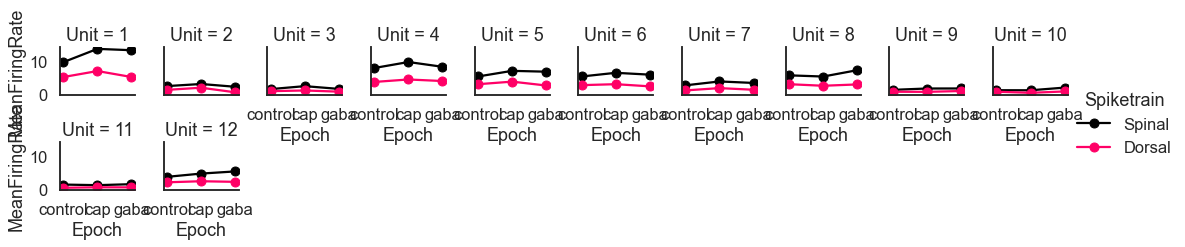

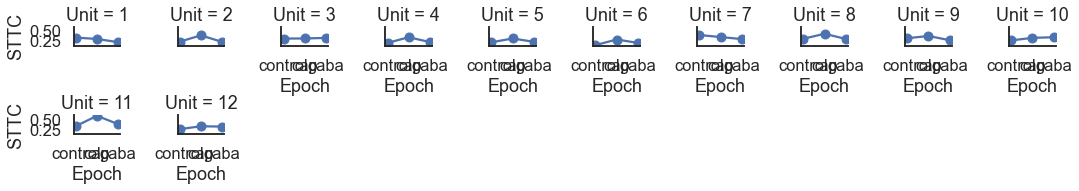

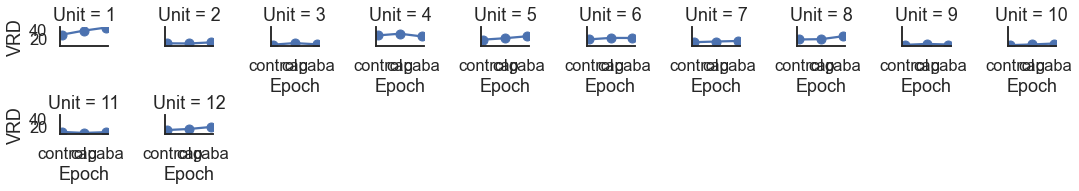

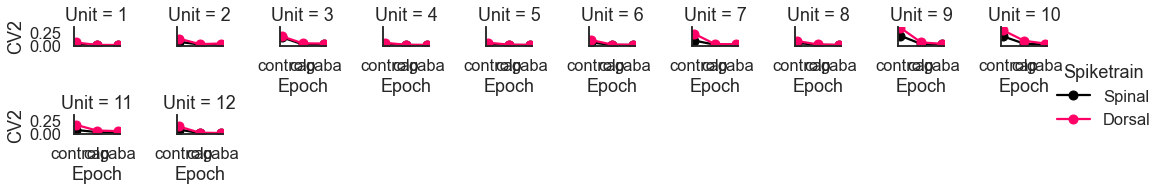

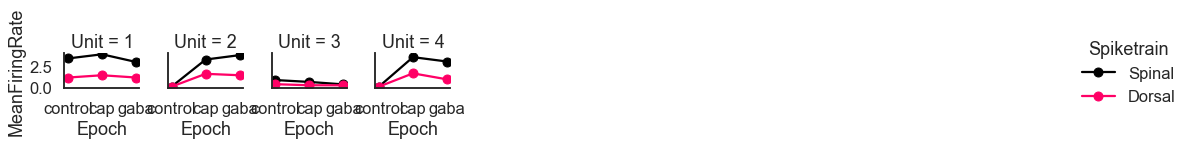

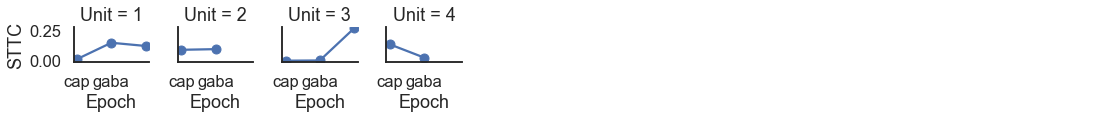

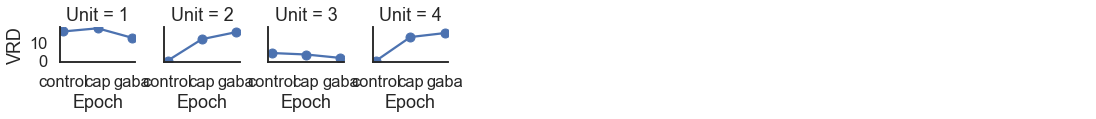

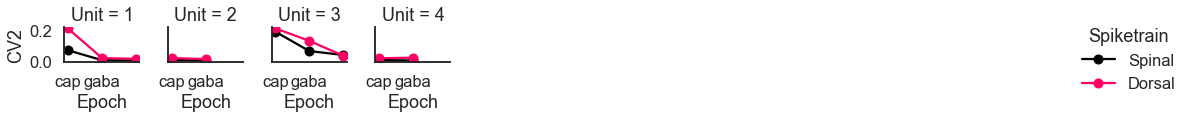

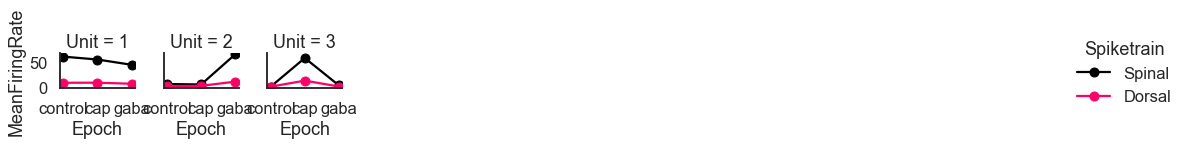

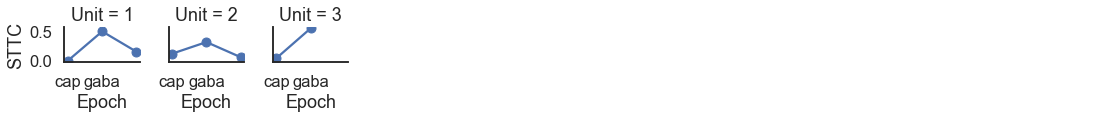

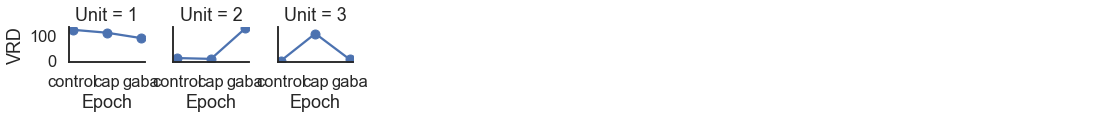

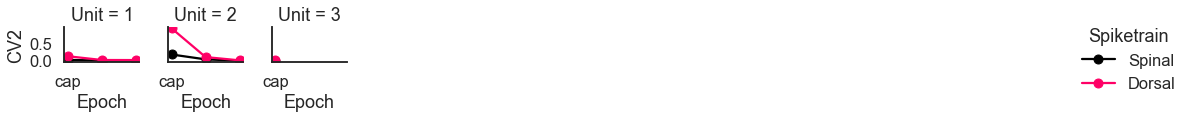

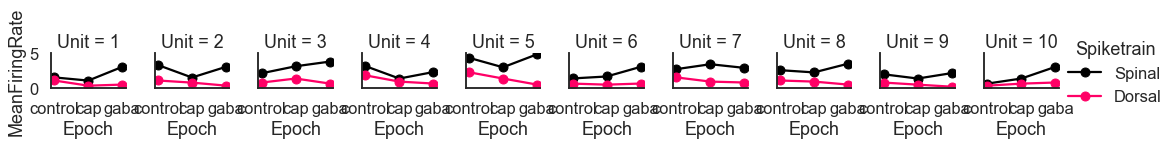

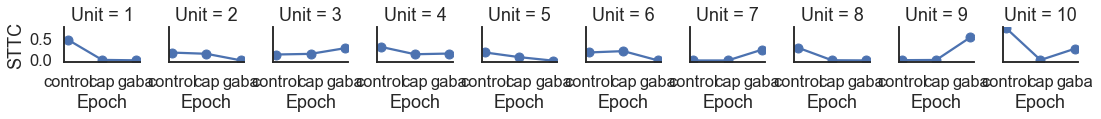

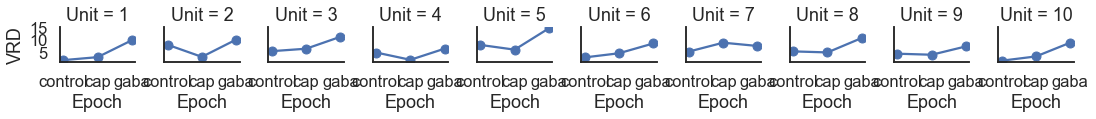

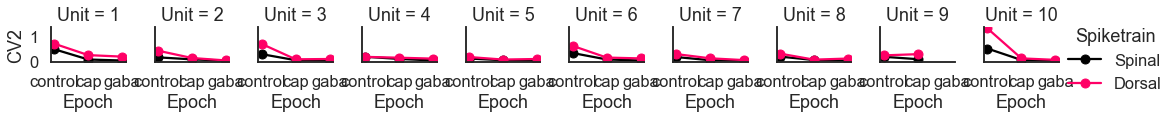

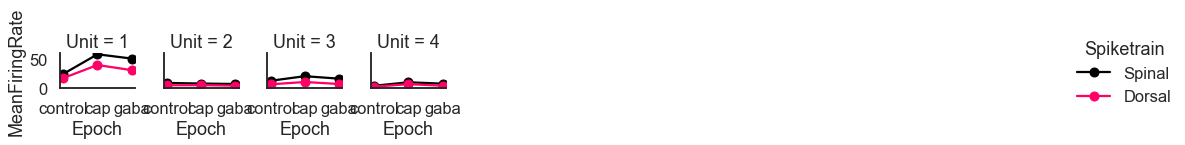

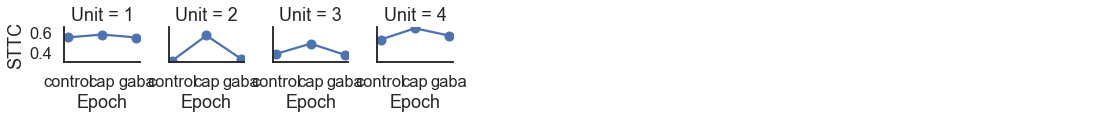

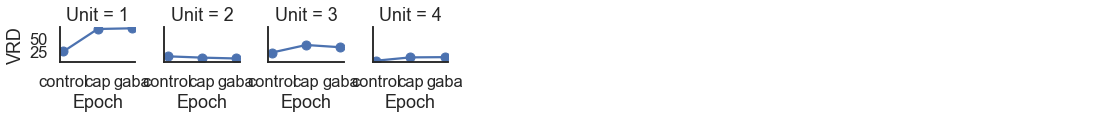

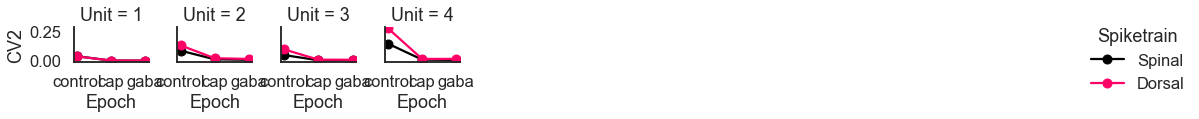

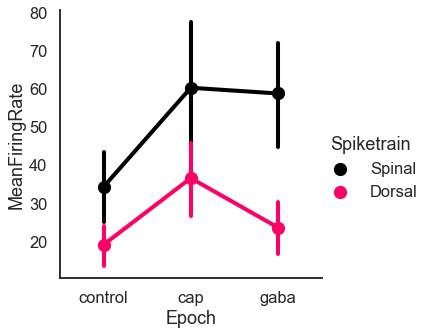

In [11]:
core_df, core_global = scrape_block_analysis()

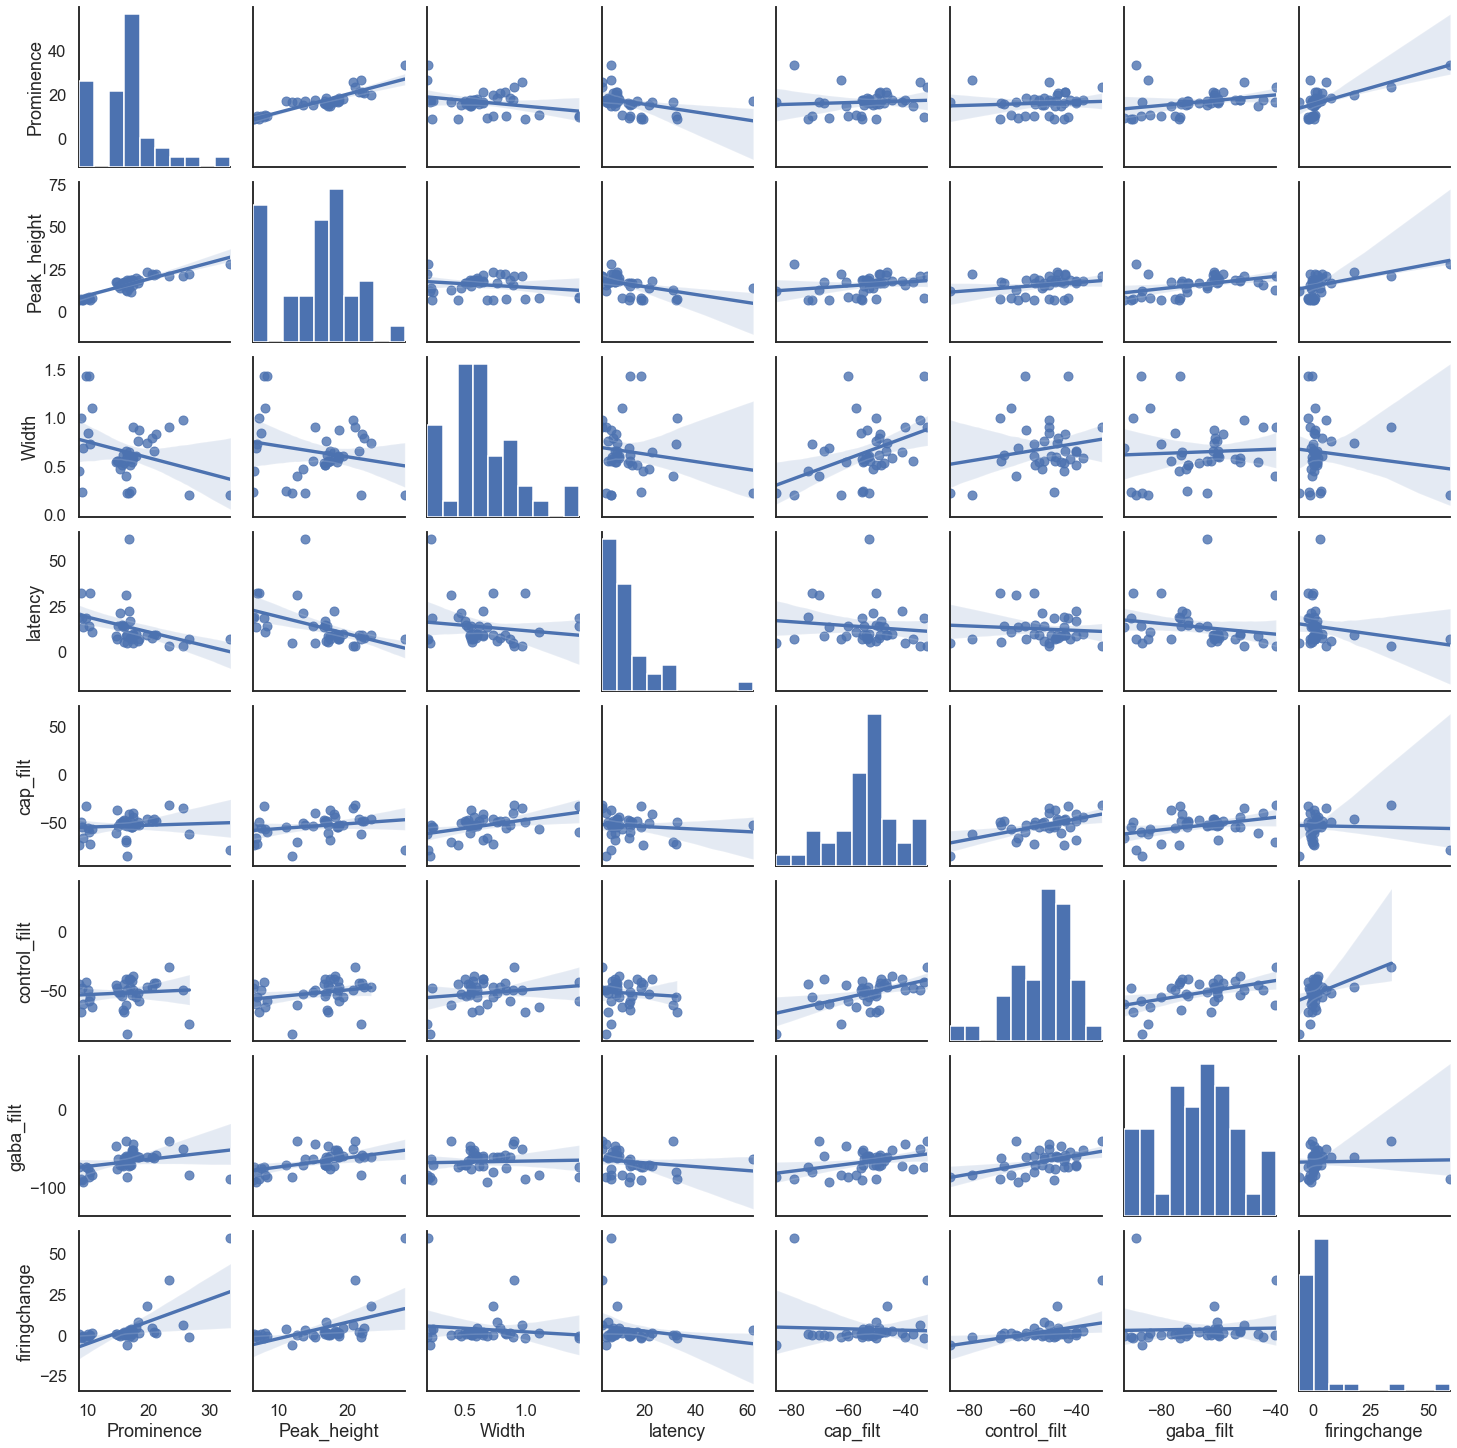

In [12]:
core_df2 = core_df.copy()
core_df2.replace([np.inf, -np.inf], np.nan, inplace=True)
sns.pairplot(core_df2.drop(["Sens", "Sample", "index", "Fibre"], axis=1), kind="reg", palette=palette[1])

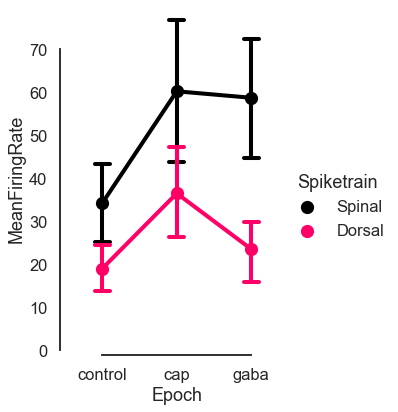

In [13]:
"""Overall comparison"""
#palette = sns.set_palette("dark", n_colors = 20)

g = sns.catplot(kind="point", data=core_global, x="Epoch", y="MeanFiringRate", 
                    hue ="Spiketrain", order = ["control","cap","gaba"], ci=68, height=6, 
                  aspect=.75, markers ="o", capsize=.2, palette = palette)


g.ax.set_ylim(bottom=0)
sns.despine(offset= 5, trim=True)
g.savefig("meanfiring.svg")


In [14]:
core_df2.head()

,index,Prominence,Peak_height,Width,Sample,latency,cap_filt,control_filt,gaba_filt,firingchange,Sens,Fibre
0,1,19.849988,23.443560,0.734831,1,9.336193,-46.175637,-47.058824,-61.589404,17.659028,True,delta
1,2,17.953143,19.469381,0.602429,1,10.069022,-52.577320,-55.555556,-60.000000,4.112000,True,delta
2,3,15.660458,16.771374,0.515733,1,15.010577,-50.000000,-55.172414,-70.689655,0.707731,False,c
3,4,17.064414,16.752345,0.507173,1,16.976563,-48.387097,-40.000000,-70.689655,1.878573,False,c
4,5,15.861905,17.071984,0.615266,1,14.461702,-48.979592,-66.666667,-72.881356,1.582349,False,c


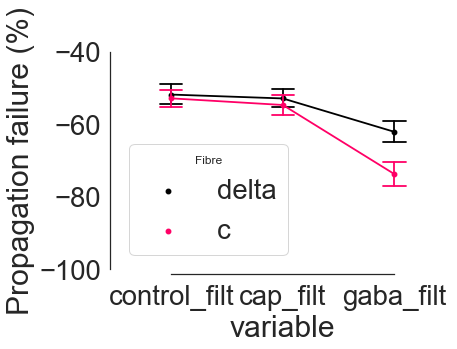

In [36]:
core_melt = core_df2.melt(id_vars = "Fibre", value_vars = ["control_filt", "cap_filt", "gaba_filt"])
#core_melt.value = abs(core_melt.value)
f = sns.pointplot(x="variable", y="value", data=core_melt,capsize=.2, hue = "Fibre", palette =palette, ci=68 )
f.set_ylabel("Propagation failure (%)")
f.set_ylim(bottom=-100, top=-40)
sns.despine(offset= 5, trim=True)
f.get_figure().savefig("meanfilteringbyfibre_neg.svg")

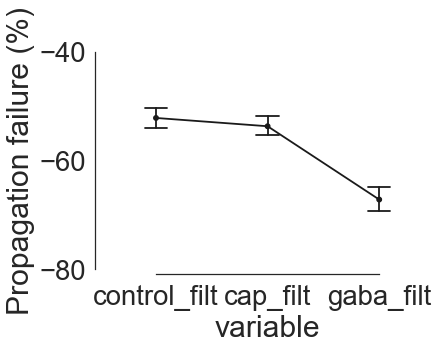

In [37]:
h = sns.pointplot(x="variable", y="value", data=core_melt,capsize=.2, ci=68, color= "k" )
h.set_ylabel("Propagation failure (%)")
h.set_ylim(bottom=-80, top=-40)
sns.despine(offset= 5, trim=True)
h.get_figure().savefig("bulkfiltering_neg.svg")

In [17]:
core_melt

,Fibre,variable,value
0,delta,control_filt,-47.058824
1,delta,control_filt,-55.555556
2,c,control_filt,-55.172414
3,c,control_filt,-40.000000
4,c,control_filt,-66.666667
...,...,...,...
118,NaN,gaba_filt,-75.000000
119,delta,gaba_filt,-39.832869
120,delta,gaba_filt,-44.444444
121,delta,gaba_filt,-60.360360


In [18]:
"""Export data for R"""
core_df2.to_csv("./UnitResults.csv")
core_global.to_csv("./GlobalResults.csv")

In [19]:
core_df2[["control_filt", "cap_filt", "gaba_filt"]].describe()

,control_filt,cap_filt,gaba_filt
count,38.000000,41.000000,41.000000
mean,-52.182175,-53.706805,-67.191682
std,11.459963,11.707155,14.031303
min,-86.976744,-85.279188,-92.857143
25%,-57.910628,-57.142857,-75.000000
50%,-50.000000,-52.631579,-64.102564
75%,-44.444444,-48.387097,-60.000000
max,-30.379747,-32.071269,-39.832869


In [20]:
core_global.head()

,Unnamed: 0,Unnamed: 1,STTC,VRD,MeanFiringRate,CV1,CV2,Epoch,Spiketrain,Sample
0,control,0,0.027141,0.000000,13.166703,1.068527,0.022531,control,Spinal,1
1,NaN,1,0.027141,21.965333,10.166695,0.673919,0.035748,control,Dorsal,1
2,cap,0,0.027542,0.000000,44.479696,0.800186,0.000853,cap,Spinal,1
3,NaN,1,0.027542,68.997551,35.889423,0.851206,0.001057,cap,Dorsal,1
4,gaba,0,0.065848,0.000000,52.178615,0.729235,0.000418,gaba,Spinal,1


In [21]:
sub = core_global[["Epoch", "Spiketrain", "MeanFiringRate", "Sample"]]
spinal_sub = sub[sub.Spiketrain =="Spinal"]
dorsal_sub = sub[sub.Spiketrain =="Dorsal"]

spinal_sub = spinal_sub.pivot(columns = "Epoch", index="Sample", values = "MeanFiringRate")
dorsal_sub = dorsal_sub.pivot(columns = "Epoch", index="Sample", values = "MeanFiringRate")

with pd.ExcelWriter("./MeanFiring.xlsx") as writer:
    spinal_sub.to_excel(writer, "spinal")
    dorsal_sub.to_excel(writer, "dorsal")
    


Text(0.5, 0, 'Latency (ms)')

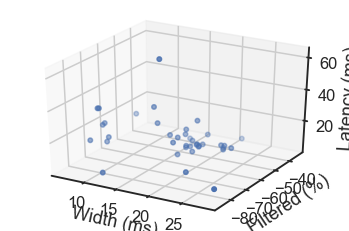

In [22]:
"""Plot multiple regression"""
core_df2.head()
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = core_df2.Peak_height
y = core_df2[["cap_filt", "gaba_filt", "control_filt"]].mean(axis=1)
z = core_df2.latency

ax.scatter(x, y, z)
ax.set_xlabel('Width (ms)')
ax.set_ylabel('Filtered (%)')
ax.set_zlabel('Latency (ms)')



In [23]:
"""Get examples for sample 3 and sample 4. Using read block"""
nixfile = filedialog.askopenfilename()
bl, st1, st2, SN, DR = sa.read_block(nixfile)

Reading block


In [24]:
bl.segments[0].epochs[0].durations



array([19.59995, 17.07495, 17.77495]) * s

In [25]:
%matplotlib inline

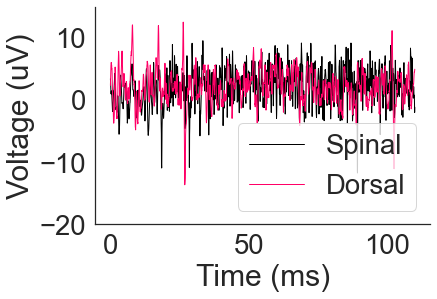

In [26]:
import quantities as pq
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1})
sns.set_style("white")  
def example_trace_plot():
    fig, ax = plt.subplots()
    SN_sig = SN.time_slice(19.58*pq.s, 19.69*pq.s)
    DR_sig = DR.time_slice(19.58*pq.s, 19.69*pq.s)
    ax.plot((SN_sig.times-SN_sig.times[0]).rescale("ms"), SN_sig.magnitude.flatten(), color = palette[0], label = "Spinal")
    ax.plot((DR_sig.times-DR_sig.times[0]).rescale("ms"), DR_sig.magnitude.flatten(), color = palette[1], label = "Dorsal")
    ax.legend()
    ax.set_ylim(bottom = -20, top = 15)
    ax.set_yticks([-20, -10, 0, 10])
    ax.set_ylabel("Voltage (uV)")
    ax.set_xlabel("Time (ms)")
    sns.despine()
    fig.savefig("example_trace_samp3.svg")
    
example_trace_plot()


In [27]:
"""Produce graph from simulation showing errors"""


'Produce graph from simulation showing errors'

In [29]:
from scipy import stats

In [30]:
grp_df = core_df2.pivot(columns = "CapSens", values = "Peak_height")
print(stats.ttest_ind(grp_df["Cap Sens"], grp_df["Cap Insens"], nan_policy = "omit"))
grp_df.describe()


Ttest_indResult(statistic=2.7453022771325686, pvalue=0.009095260828733846)


CapSens,Cap Insens,Cap Sens
count,31.000000,10.000000
mean,14.489456,19.586527
std,5.171871,4.876738
min,6.424568,11.216239
25%,8.227742,17.287724
50%,16.752345,20.134795
75%,18.323321,22.070351
max,22.100870,28.315207


In [31]:
grp_df.to_csv("cap_sens_amp_df.csv")

C:\Users\pierc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


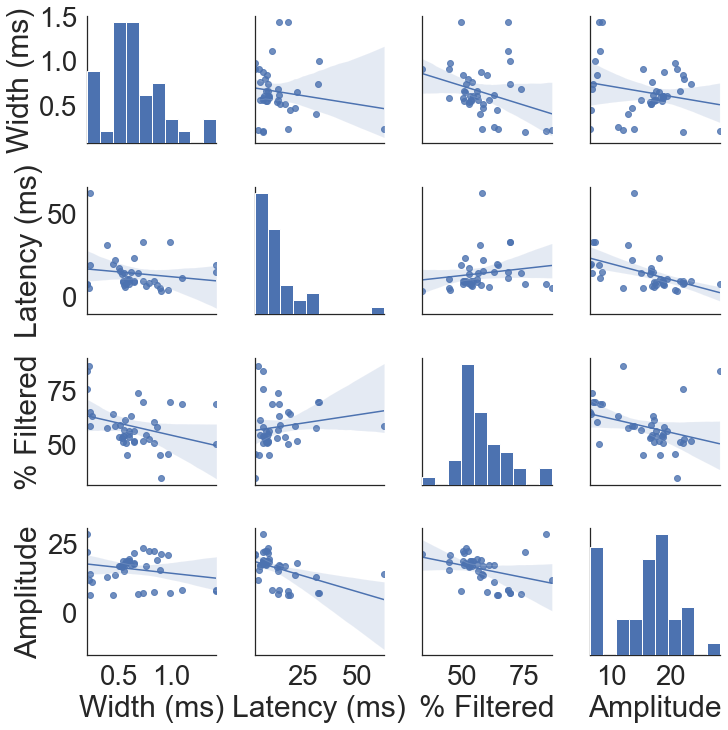

In [32]:
"""Show correlation between % filtered and latency, width etc"""
core_df2.head()
correlation = core_df2[["Width", "latency", "Mean_filt", "Peak_height"]]
correlation["Mean_filt"] = np.abs(correlation["Mean_filt"])
correlation.columns = ["Width (ms)", "Latency (ms)", "% Filtered", "Amplitude"]#, "Cap Δ Freq (Hz)"]
corr_fig = sns.pairplot(correlation, kind="reg")
#corr_fig.map_offdiag(sns.scatterplot,color=palette[0])
#corr_fig.map_diag(plt.hist,color=palette[2])
corr_fig.fig.savefig("correlation.svg")

In [34]:
"""Breakdown of spike types"""
core_df2

,index,Prominence,Peak_height,Width,Sample,latency,cap_filt,control_filt,gaba_filt,firingchange,Sens,Fibre,Mean_filt,CapSens
0,1,19.849988,23.443560,0.734831,1,9.336193,-46.175637,-47.058824,-61.589404,17.659028,True,delta,-51.607955,Cap Sens
1,2,17.953143,19.469381,0.602429,1,10.069022,-52.577320,-55.555556,-60.000000,4.112000,True,delta,-56.044292,Cap Sens
2,3,15.660458,16.771374,0.515733,1,15.010577,-50.000000,-55.172414,-70.689655,0.707731,False,c,-58.620690,Cap Insens
3,4,17.064414,16.752345,0.507173,1,16.976563,-48.387097,-40.000000,-70.689655,1.878573,False,c,-53.025584,Cap Insens
4,5,15.861905,17.071984,0.615266,1,14.461702,-48.979592,-66.666667,-72.881356,1.582349,False,c,-62.842538,Cap Insens
5,6,15.976949,16.586186,0.529704,1,13.541667,-47.272727,-44.444444,-66.666667,1.898556,False,c,-52.794613,Cap Insens
6,7,17.488400,18.223280,0.581509,1,10.035385,-44.642857,-37.500000,-52.459016,2.506814,True,delta,-44.867291,Cap Sens
7,8,15.412644,13.559770,0.468738,1,21.645000,-51.020408,-52.727273,-71.428571,-0.473212,False,c,-58.392084,Cap Insens
8,9,15.069320,15.099612,0.550797,1,14.181818,-54.285714,-51.724138,-64.102564,0.233422,False,c,-56.704139,Cap Insens
9,10,16.754370,18.062353,0.648235,1,22.686792,-40.909091,-40.000000,-72.727273,1.207732,False,c,-51.212121,Cap Insens
